In [2]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [3]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

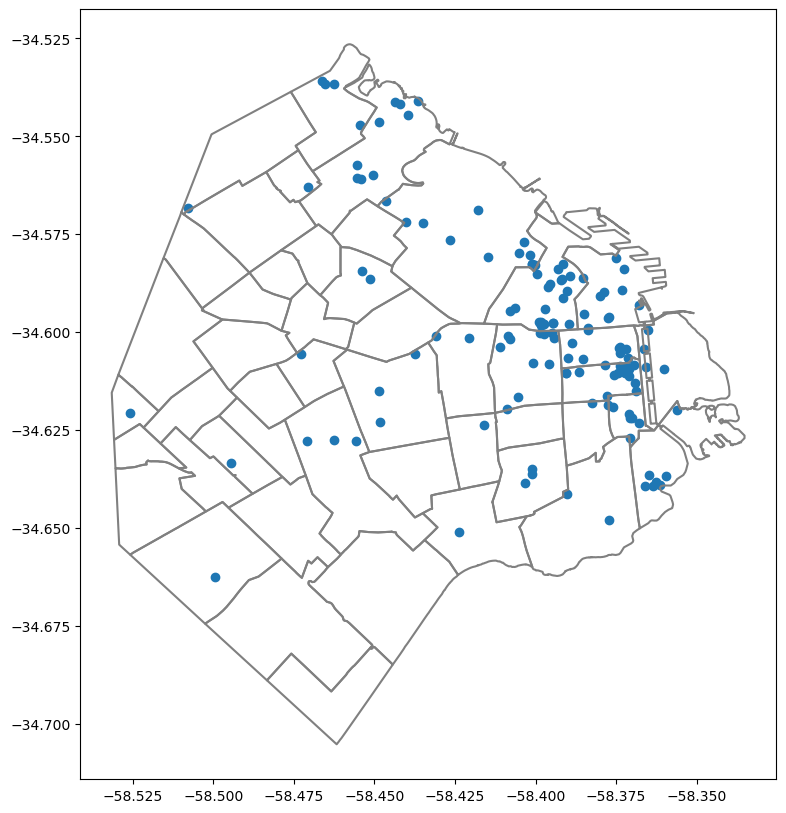

In [4]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [5]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [6]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [7]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

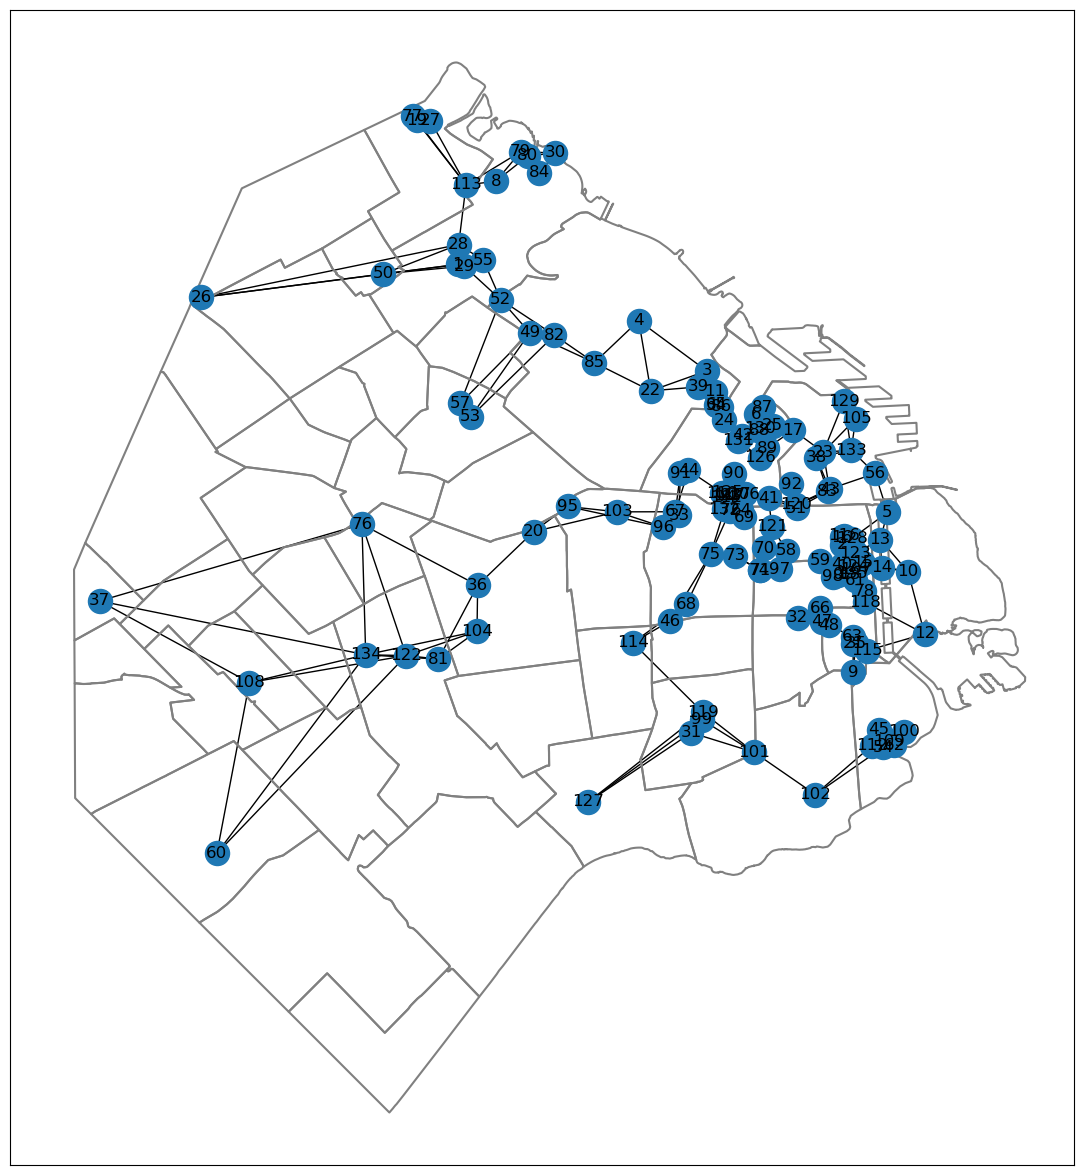

In [8]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

## Punto 1: 
----
Partiendo de la ecuación

$$
\mathbf{p} = (1-\alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1}
$$

muestre que el vector de rankings **p** es solución de la ecuación     $M\mathbf{p} = \mathbf{b}$  , con    $M = \frac{N}{\alpha}(I - (1-\alpha)C)$    y    $\mathbf{b} = \mathbf{1}$  .


### Resolución

La ecuación es:

$$
\mathbf{p} = (1-\alpha)C\mathbf{p} + \frac{\alpha}{N}\mathbf{1},
$$

luego:

$$\mathbf{p} - (1-\alpha)C\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$\mathbf{p}I - (1-\alpha)C\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$(I - (1-\alpha)C)\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$\frac{N}{\alpha}(I - (1-\alpha)C)\mathbf{p} = \mathbf{1}$$

y con $M = \frac{N}{\alpha}(I - (1-\alpha)C)$ resulta lo pedido: $M\mathbf{p} = \mathbf{b} = \mathbf{1}$.


## Punto 2:
----
¿Qué condiciones se deben cumplir para que exista una única solución a la ecuación del
punto anterior? ¿Se cumplen estas condiciones para la matriz $M$ tal como fue construida
para los museos, cuando $0 < \alpha < 1$? Demuestre que se cumplen o dé un contraejemplo.


Dado el ítem anterior, la ecuación $Mp = 1$ tendrá solución única cuando $M$ sea inversible. Una condición necesaria y suficiente para esto es que el núcleo de $M$ sea $\{0\}$.

Primero, usando el tip dado en clase, pruebo:

$$
\text{Si} \quad B \in \mathbb{R}^{n \times n} \quad \text{y} \quad \|B\|_1 < 1 \quad \text{entonces} \quad (I-B) \quad \text{es inversible}.
$$

Supongamos que existe $(I-B)^{-1}$. Entonces, si existiera $x \neq 0$ en $\mathbb{R}^{n}$ tal que $(I-B)x = 0$, tendríamos:

$$
x - Bx = 0
$$

lo que equivale a

$$
x = Bx.
$$

Uso la norma-1 (que preserva la igualdad) y puedo suponer que $\|x\|_1 = 1$. Entonces:

$$
\|x\|_1 = \|Bx\|_1 \quad \Rightarrow \quad 1 = \|Bx\|_1.
$$

Además, se cumple que $\|Bx\|_1 \leq \|B\|_1 \|x\|_1$ y, usando la hipótesis $\|B\|_1 < 1$, resulta:

$$
\|Bx\|_1 \leq \|B\|_1 \|x\|_1 = \|B\|_1 < 1.
$$

Por lo tanto, tenemos que:

$$
\|Bx\|_1 = 1 \quad \text{y} \quad \|Bx\|_1 < 1,
$$

lo cual es imposible. Como lo único que supusimos fue que $x \neq 0$, debe ser entonces que solamente se cumple $(I-B)x = 0$ si $x = 0$. Por lo tanto, $(I-B)$ es inversible.

---

Volviendo al problema original: $Mp = 1$ tendrá solución única si la matriz $M$ resulta inversible, es decir, si $(I - (1-\alpha)C)$ es inversible.

Por un lado, observamos que $\|C\|_1 = 1$ dado que, por definición, sus columnas suman 1. Por otro lado, como $0 < \alpha < 1$, se cumple que $1-\alpha < 1$.

Es decir:

$$
\|(1-\alpha)C\|_1 = (1-\alpha)\|C\|_1 < 1.
$$

Esto es análogo al problema anterior sobre la existencia de $(I-B)^{-1}$, por lo tanto $(I - (1-\alpha)C)^{-1}$ existe, y la solución $p$ es única con la matriz $M$ y $\alpha$ así definidos.


## Punto 3:
----
Usando la factorización $LU$ implementada, encuentre el vector $\mathbf{p} = M^{-1} \mathbf{b}$ en los siguientes casos:

**a.** Construyendo la red conectando a cada museo con sus $m = 3$ vecinos más cercanos, calculen el Page Rank usando $\alpha = 1/5$. Visualicen la red asignando un tamaño a cada nodo proporcional al Page Rank que le toca.

**b.** Construyendo la red conectando a cada museo con sus $m$ vecinos más cercanos, para $m = 1, 3, 5, 10$ y usando $\alpha = 1/

**c.** Para $m = 5$, considerando los valores de $\alpha = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7$

-----

Usando los valores de $\mathbf{p}$ obtenidos para cada caso,

**a.** Identifiquen los 3 museos más centrales (para cada $m$ y cada $\alpha$) y grafiquen sus puntajes (valores de Page Rank) en función del parámetro a variar (es decir, en función de $m$ o de $\alpha$). ¿Son estables las posiciones en el ranking? Describa los distintos patrones que observa, identificando qué ubicaciones son relevantes en cada caso. ¿Hay museos que sólo son relevantes en redes con pocas conexiones? ¿O museos que se vuelven más relevantes mientras más conexiones aparecen?

**b.** Construyan visualizaciones del mapa, usando el Page Rank para representar el tamaño de cada museo. ¿Qué regiones se vuelven más predominantes al aumentar $\alpha$? ¿Y al aumentar $m$?


In [9]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import template_funciones as tf
from IPython.display import display
importlib.reload(tf)

<module 'template_funciones' from 'C:\\Users\\Draken\\Dropbox\\UBA\\ALC\\TP1\\template_funciones.py'>

In [11]:
# Definimos los valores de m a analizar
valores_m = [1, 3, 5, 10]
alfa_fijo = round(1/5, 5)

# Diccionarios para guardar matrices de adyacencia, grafos y pageranks
adyacencias_m = {}
grafos_m = {}
pageranks_m = {}

for m in valores_m:
    A = tf.construye_adyacencia(D, m)
    adyacencias_m[m] = A
    grafos_m[m] = nx.from_numpy_array(A)
    pageranks_m[m] = tf.calcula_pagerank(A, alfa_fijo)

# PageRank para distintos valores de α con m=5 fijo
valores_alfa = [round(6/7, 5), round(4/5, 5), round(2/3, 5), round(1/2, 5), round(1/3, 5), round(1/5, 5), round(1/7, 5)]
m_fijo = 5
A_fijo = adyacencias_m[m_fijo]  # Ya lo calculamos arriba

pageranks_alfa = {}

for alfa in valores_alfa:
    alfa_key = round(alfa, 5)  # Redondeamos para evitar errores al usar un float como key
    p = tf.calcula_pagerank(A_fijo, alfa)
    pageranks_alfa[alfa_key] = p
    
# Layouts
coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: (x, y) for i, (x, y) in enumerate(zip(coords['x'], coords['y']))}

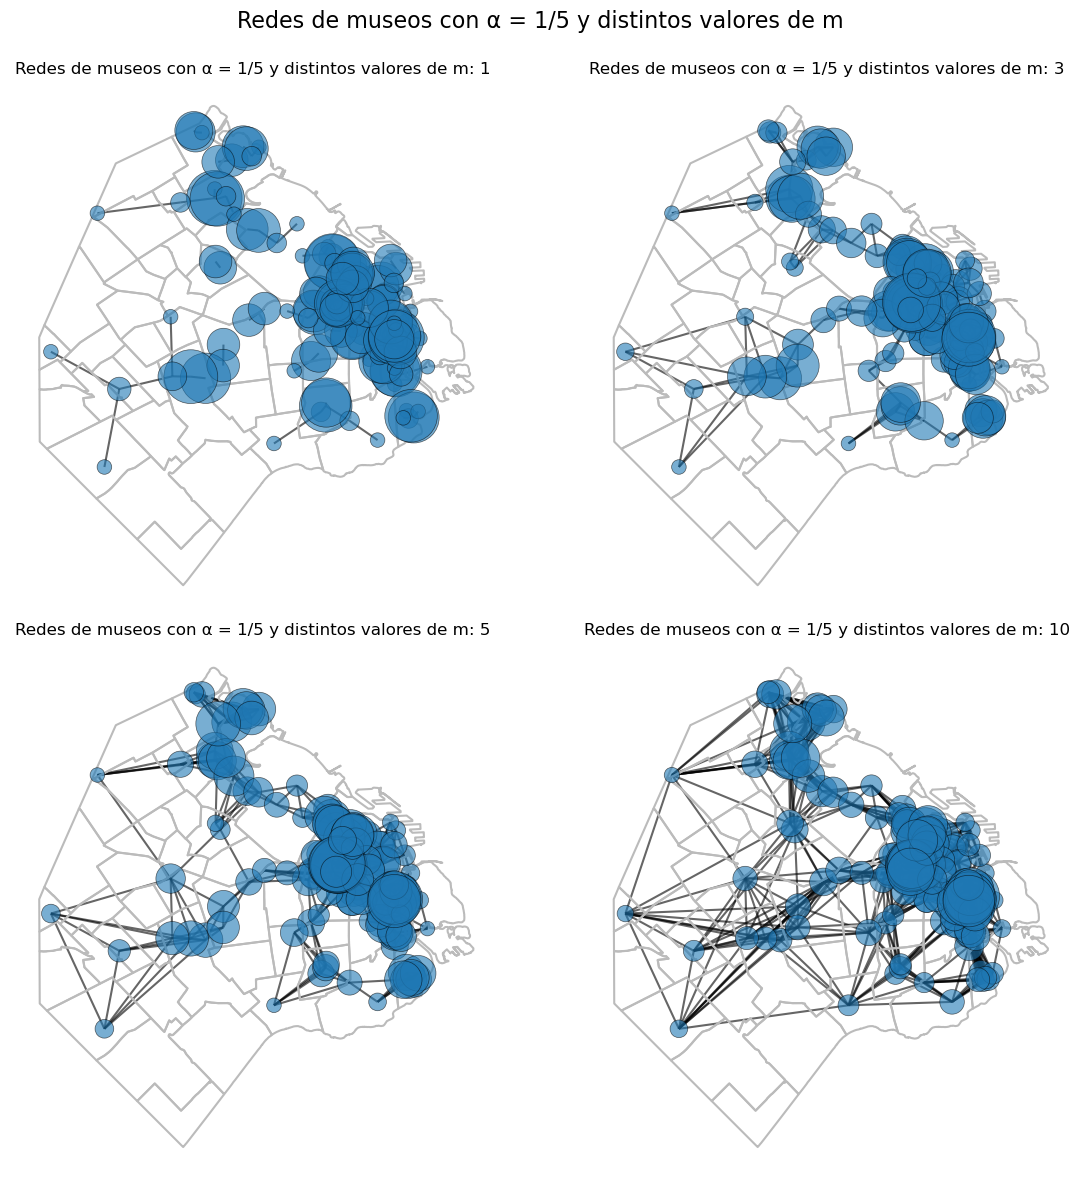

In [12]:
# Mostrar redes para distintos m (con α = 1/5 fijo)
tf.graficar_redes_museos_set(
    grafos=grafos_m,
    pageranks=pageranks_m,
    G_layout=G_layout,
    barrios=barrios,
    titulo_general="Redes de museos con α = 1/5 y distintos valores de m"
)

En estos gráficos se observa cómo varía la red de museos al modificar el parámetro $m$, que indica con cuántos vecinos se conecta cada museo (sus $m$ más cercanos). A medida que $m$ aumenta, la red se vuelve progresivamente más densa, y eso tiene consecuencias sobre la distribución del PageRank.

Con valores bajos de $m$ (por ejemplo, $m = 1$ o $m = 3$), la red presenta una estructura más fragmentada: aparecen pequeñas zonas relativamente autónomas, en las que ciertos museos son centrales dentro de su subregión (por ejemplo, museos ubicados en Caballito y Flores, la zona norte de CABA y Microcentro). Esto se refleja en el PageRank, donde varios nodos periféricos en el grafo completo tienen una alta centralidad dentro de su grupo local.

Sin embargo, a medida que $m$ aumenta (por ejemplo, en $m = 10$), estas subregiones comienzan a conectarse entre sí y se forma una estructura más integrada. En este contexto, los nodos centrales del Microcentro y los de la zona norte empiezan a dominar el ranking, desplazando a aquellos que antes eran importantes solo dentro de su vecindario. Es decir, pasamos de una red con múltiples polos locales de centralidad a una red con una o dos zonas centrales más clara y dominante.

Este comportamiento muestra cómo el valor de $m$ influye en el grado de descentralización de la red: con $m$ bajos emergen estructuras locales, mientras que con $m$ altos la red converge hacia un patrón de conectividad más global, en el que solo unos pocos nodos concentran la mayor parte del PageRank.


---

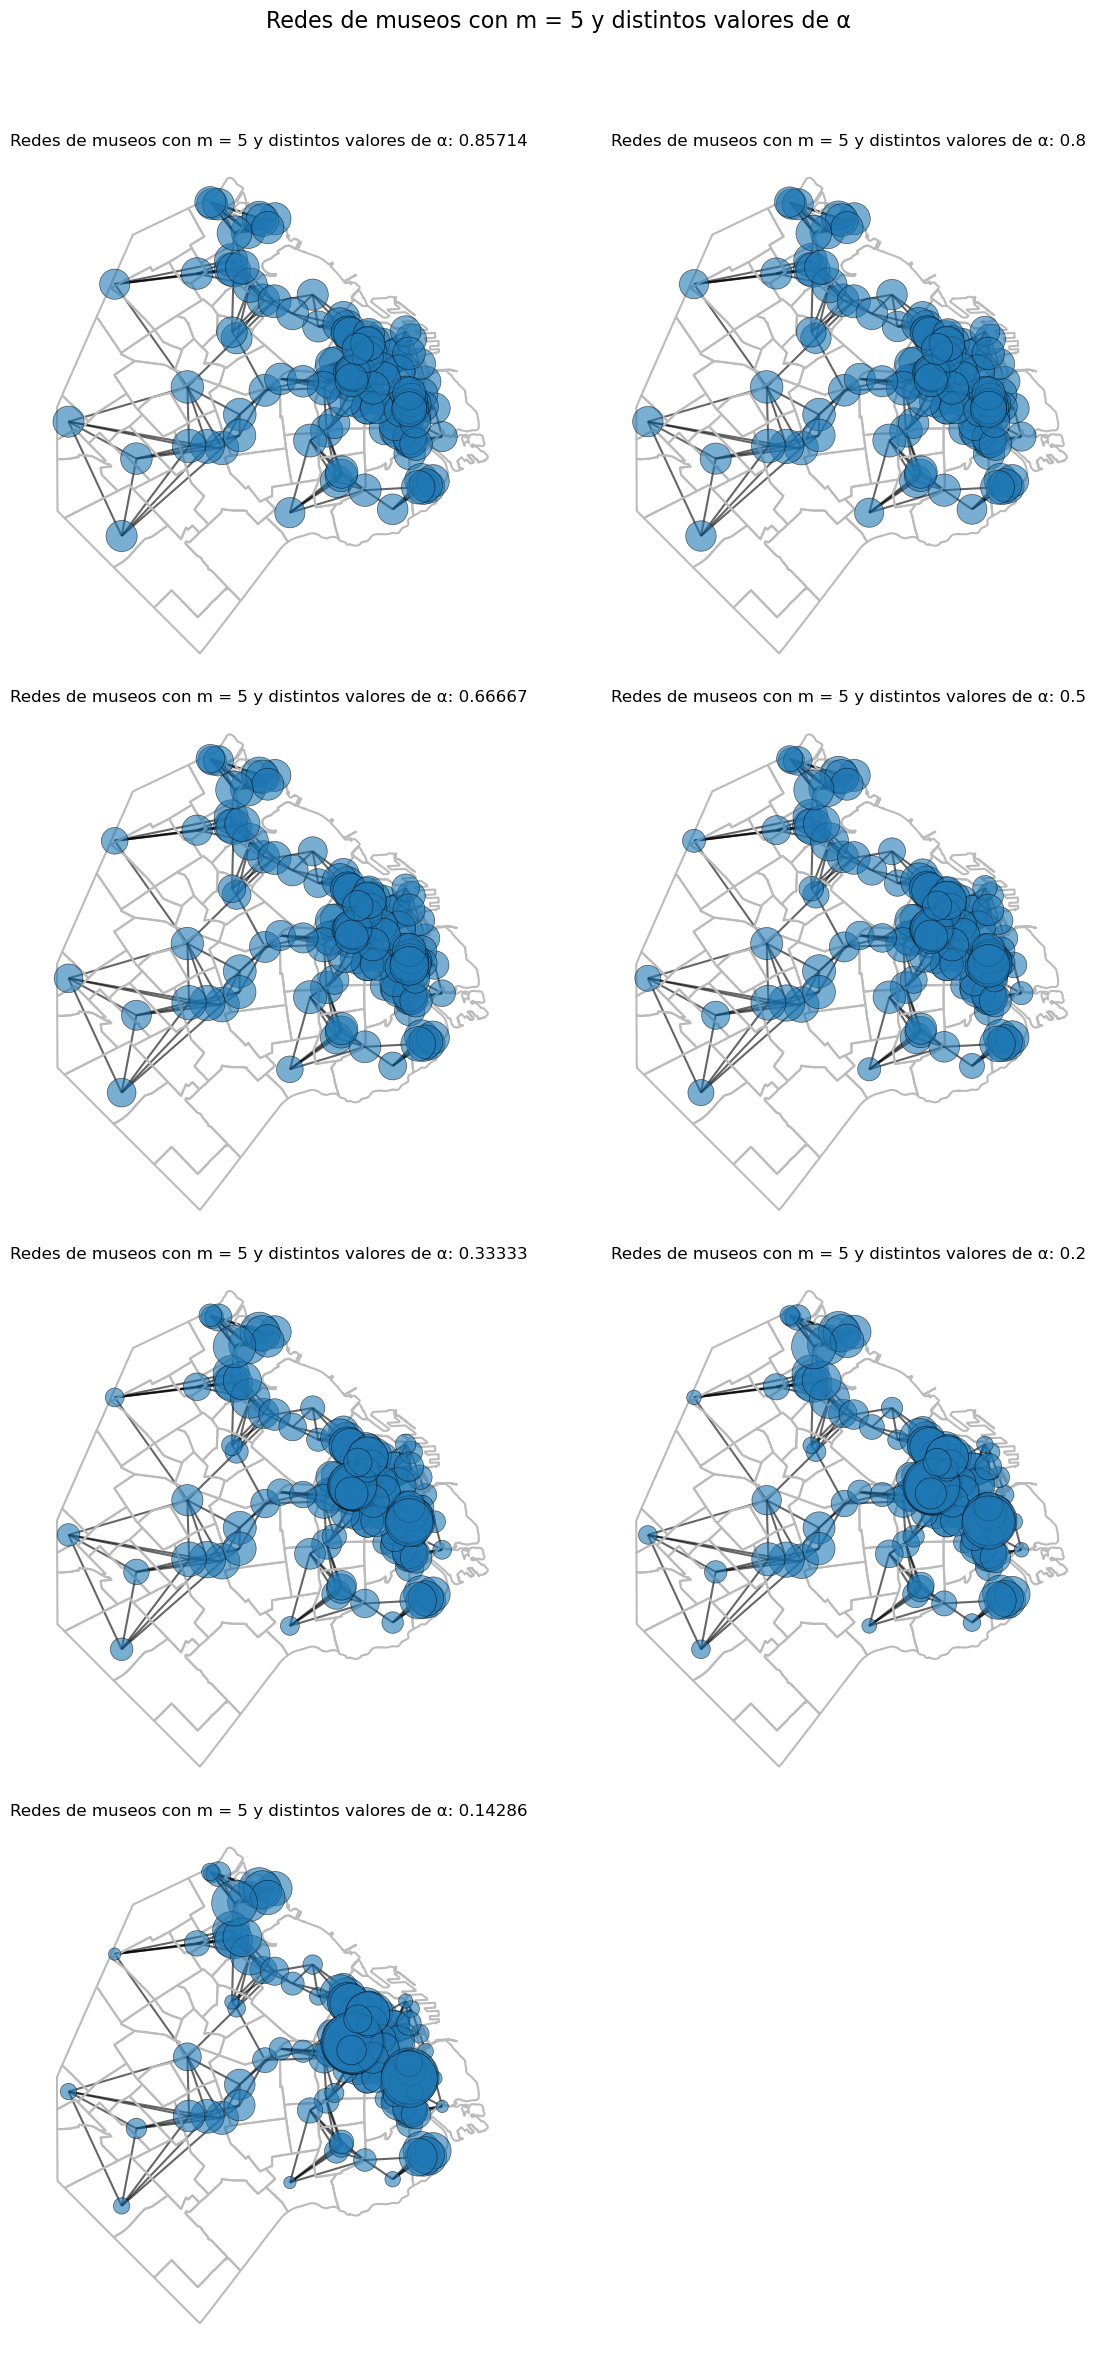

In [13]:
# Mostrar redes para distintos α (con m = 5 fijo)
# Creamos un diccionario de grafos con m=5 fijo
grafos_alfa = {round(alfa, 5): grafos_m[5] for alfa in valores_alfa}

tf.graficar_redes_museos_set(
    grafos=grafos_alfa,
    pageranks=pageranks_alfa,
    G_layout=G_layout,
    barrios=barrios,
    titulo_general="Redes de museos con m = 5 y distintos valores de α"
)

En este caso, como el valor de $m$ está fijo en 5, todos los grafos tienen exactamente las mismas conexiones entre museos. Lo que cambia entre gráficos es el valor del parámetro $\alpha$, que controla la probabilidad de que un caminante reinicie su recorrido en un nodo aleatorio.

Cuando $\alpha$ está cerca de 1, por ejemplo $\alpha = \frac{6}{7}$, hay mucha probabilidad de reiniciar la caminata en cualquier museo. Eso hace que los valores de PageRank se repartan de forma bastante uniforme: todos los nodos tienen más o menos el mismo tamaño. En cambio, cuando $\alpha$ se acerca a 0, como en $\alpha = \frac{1}{7}$, el caminante sigue los enlaces de la red casi sin reiniciar, y eso acentúa las diferencias entre nodos. En ese caso, los museos más bien ubicados o con más caminos que llegan a ellos se destacan mucho más.

En resumen, cuanto más chico es $\alpha$, más influye la estructura de la red en el resultado del PageRank. Y cuanto más grande es $\alpha$, más uniforme es la distribución del ranking entre los nodos.

---

Para la segunda parte, haremos primero el análisis para $m=5$ y $\alpha = \frac{1}{5}$ y haremos variar $m$ dejando $\alpha$ fijo.

In [49]:
# Obtenemos el top 3 de museos más centrales para m = 5 y 𝛼 = 1/5
p_copy = pageranks_m[5].copy()
top_idx = []

for i in range(3):
    max_val = -1
    max_idx = -1

    # Recorremos p_copy para buscar el maximo y su posicion
    for idx in range(len(p_copy)):
        if p_copy[idx] > max_val:
            max_val = p_copy[idx]
            max_idx = idx
        
    top_idx.append(max_idx)
    print(f"{i+1}° → Museo #{max_idx} con PageRank = {max_val:.4f}")
        
    # Lo sacamos para encontrar el resto del Top
    p_copy[max_idx] = -1

1° → Museo #93 con PageRank = 0.0217
2° → Museo #125 con PageRank = 0.0216
3° → Museo #117 con PageRank = 0.0211


Ahora analizaremos la evolución de estos 3 museos de referencia al variar $m$.

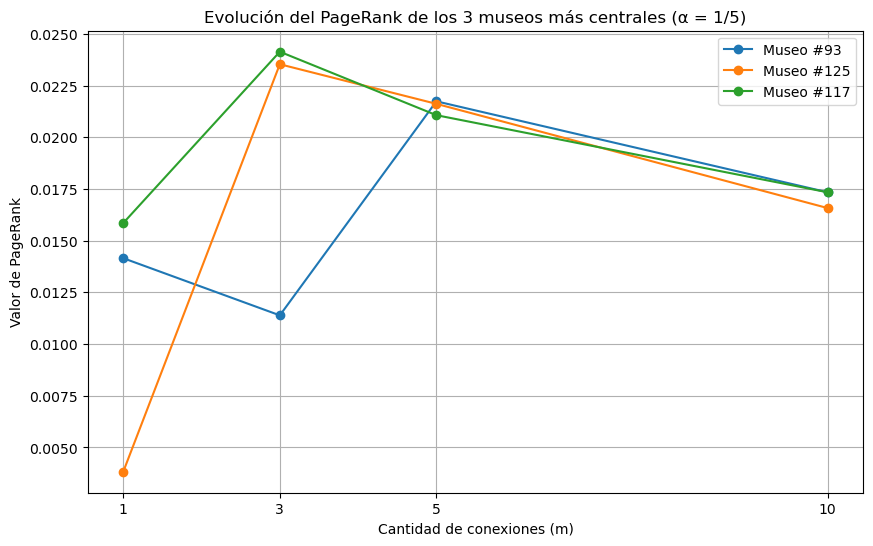

In [50]:
# Inicializamos un diccionario vacío para guardar la evolución de cada museo
evolucion_p_m = {idx: [] for idx in top_idx}

# Recorremos cada valor de m
for m in valores_m:
    p = pageranks_m[m]
    for idx in top_idx:
        evolucion_p_m[idx].append(p[idx])  # Guardamos el PageRank correspondiente
        
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_m, evolucion_p_m[idx], marker='o', label=f"Museo #{idx}")

# Vector de etiquetas
labels_m = ["1", "3", "5", "10"]
plt.xticks(valores_m, labels_m)  # Aseguramos que se usen los valores como etiquetas explícitas

plt.xlabel("Cantidad de conexiones (m)")
plt.ylabel("Valor de PageRank")
plt.title("Evolución del PageRank de los 3 museos más centrales (α = 1/5)")
plt.grid(True)
plt.legend()
plt.show()

Se aprecia que, en general, los valores de PageRank tienden a incrementarse cuando pasamos de $m = 1$ a $m = 3$, y luego decrecen levemente al seguir aumentando $m$ a $5$ y $10$. Esto puede interpretarse como un efecto de dispersión: con pocas conexiones, la importancia se concentra en unos pocos nodos; a medida que se agregan más enlaces, la centralidad se redistribuye y los valores de PageRank tienden a equilibrarse entre más museos.

---

Hacemos lo mismo pero en función de $\alpha$:

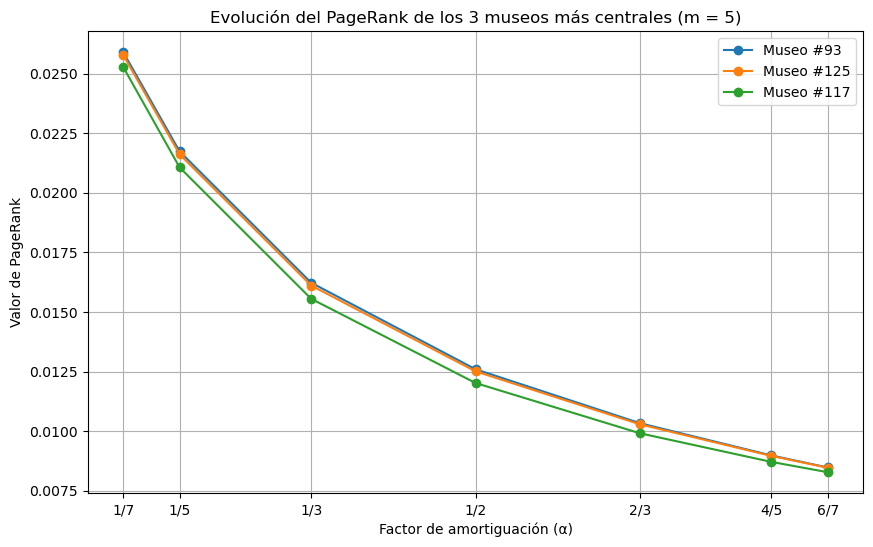

In [51]:
# Inicializamos un diccionario vacío para guardar la evolución de cada museo
evolucion_p_alfa = {idx: [] for idx in top_idx}

# Recorremos cada valor de m
for m in valores_alfa:
    p = pageranks_alfa[m]
    for idx in top_idx:
        evolucion_p_alfa[idx].append(p[idx])  # Guardamos el PageRank correspondiente
        
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_alfa, evolucion_p_alfa[idx], marker='o', label=f"Museo #{idx}")

# Vector de etiquetas
labels_alfa = ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"]
plt.xticks(valores_alfa, labels_alfa)

plt.xlabel("Factor de amortiguación (α)")
plt.ylabel("Valor de PageRank")
plt.title("Evolución del PageRank de los 3 museos más centrales (m = 5)")
plt.grid(True)
plt.legend()
plt.show()

Se ve que cuanto más grande es $\alpha$, más se reparten los valores de PageRank entre todos los nodos (recordemos que p es un vector estocástico), y los más centrales bajan un poco. Esto pasa porque al aumentar $\alpha$, el modelo depende más de cómo está conectada la red, y menos del "salto aleatorio". En cambio, cuando $\alpha$ es chico, se favorece más a los nodos a los que se llega seguido, y eso hace que se destaquen más en el ranking.

---

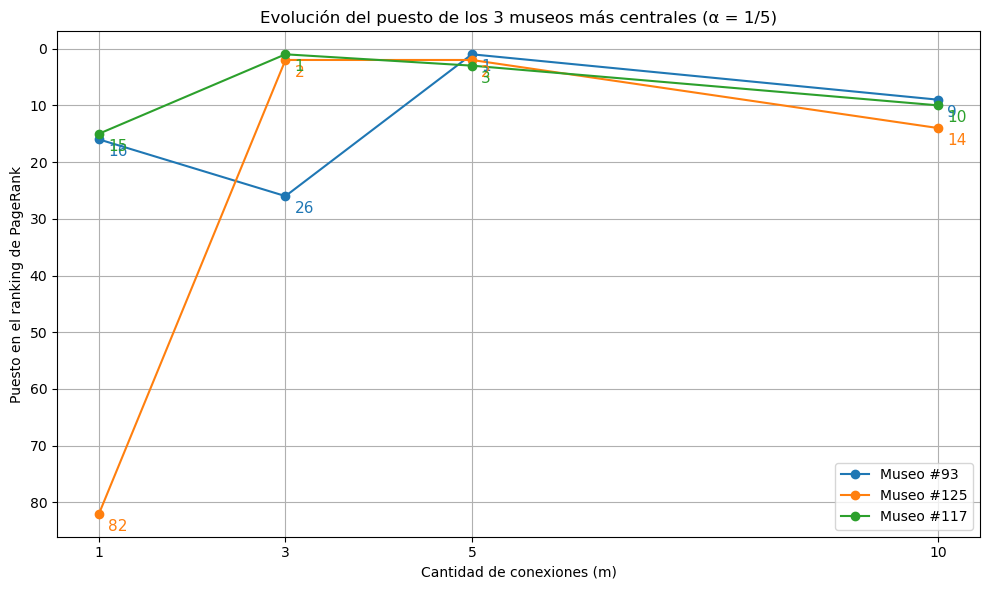

In [47]:
# Diccionario para guardar la evolución del puesto de cada museo
puestos_m = {idx: [] for idx in top_idx}

for m in valores_m:
    p = pageranks_m[m]
    
    # Vector de índices ordenados de mayor a menor
    ranking = np.argsort(p)[::-1]  
    
    for idx in top_idx:
        # np.where devuelve los índices donde se cumple la condición del argumento
        puesto = np.where(ranking == idx)[0][0] + 1  # +1 para que el ranking empiece en 1
        puestos_m[idx].append(puesto)


colores = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))

for color, idx in zip(colores, top_idx):
    puestos = puestos_m[idx]
    plt.plot(valores_m, puestos, marker='o', label=f"Museo #{idx}", color=color)

    for x, y in zip(valores_m, puestos):
        plt.text(x + 0.1, y + 3, str(y), fontsize=11, color=color)

plt.xticks(valores_m, labels_m)
plt.xlabel("Cantidad de conexiones (m)")
plt.ylabel("Puesto en el ranking de PageRank")
plt.title("Evolución del puesto de los 3 museos más centrales (α = 1/5)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Podemos observar que al aumentar el valor de $m$ (entre 1 y 10), se observa una notable inestabilidad en el ranking de los museos más centrales. Uno de los museos que ocupa el segundo puesto con $m = 5$ cae al puesto 82 cuando m = 1. Esta gran variación sugiere que el número de conexiones tiene un impacto decisivo en la estructura de la red: con pocos enlaces ($m$ chico), la red es más local y sensible a cambios puntuales; en cambio, a medida que $m$ crece, el ranking se estabiliza y los museos centrales tienden a mantener posiciones altas. A partir de $m = 5$, los rankings se vuelven más estables entre sí.

---

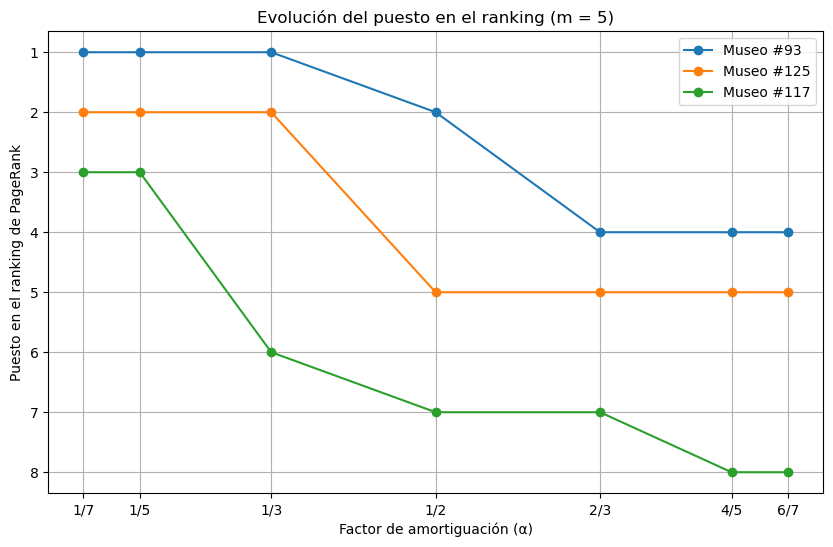

In [48]:
# Diccionario para guardar la evolución del puesto de cada museo
puestos_alfa = {idx: [] for idx in top_idx}

for alfa in valores_alfa:
    p = pageranks_alfa[alfa]
    
    # Vector de índices ordenados de mayor a menor
    ranking = np.argsort(p)[::-1]
    
    for idx in top_idx:
        # np.where devuelve los índices donde se cumple la condición del argumento
        puesto = np.where(ranking == idx)[0][0] + 1  # +1 para que el ranking empiece en 1
        puestos_alfa[idx].append(puesto)

# Graficamos los resultados
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_alfa, puestos_alfa[idx], marker='o', label=f"Museo #{idx}")

plt.xticks(valores_alfa, labels_alfa)  # Ya habías definido estas etiquetas como fracciones
plt.xlabel("Factor de amortiguación (α)")
plt.ylabel("Puesto en el ranking de PageRank")
plt.title("Evolución del puesto en el ranking (m = 5)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.show()

Al variar $\alpha$ (entre 1/7 y 6/7), se evidencia una estabilidad mucho mayor en los puestos de los museos más centrales. Los tres museos analizados mantienen posiciones altas con variaciones pequeñas y progresivas. Esto indica que el PageRank es menos sensible a cambios en $\alpha$ (dentro del rango considerado), y que los museos más importantes siguen siendo favorecidos en el ranking incluso cuando el peso relativo de la caminata aleatoria frente al salto aleatorio varía.

---

## Punto 4:

Si $V_{0}$ es la distribución inicial, o cantidad inicial de visitantes en cada museo, y considero la matriz C, entonces para un elemento i cualquiera de $CV_{0}$, tengo que i = $c_{1,i}*v_{1} + c_{2,i}*v_{2} + \ldots + c_{n,i}*v_{n}$ que no es otra cosa que la suma de la cantidad de visitantes que cada museo distinto del i (si i=j $c_{ij} = 0$) le aporta al i.

De forma análoga pero partiendo de otra cantidad inicial $V_{1} = CV_{0}$ nos dara la cantidad de visitantes por museo luego de 2 pasos.
Al final, como menciona el tip, $C^{k}V_{0} = V_{k}$ nos dara la cantida de visitantes por museo luego de k pasos.

Dada la matriz $B$ y $V_{0}$ tengo que: $Bv_{0} = C^{0}v_{0} + C^{1}v_{0} + \ldots + C^{r-1}v_{0}$. Por lo mencionado antes, resulta que, por ejemplo: $C^{0}v_{0} + C^{1}v_{0}$ será la cantidad total de gente que visitó cada museo luego de dos pasos.
En general $C^{0}v_{0} + C^{1}v_{0} + \ldots + C^{r-1}v_{0}$ da la totalidad de visitantes por museo, es decir, w, luego de k pasos.
Si asumo la existencia de $B^{-1}$, para cada r, entonces para cada total de visitantes por museo w tengo la distribución inicial $V_{0}$ que lo generó.

## Punto 5:

Usando la ecuación  

$$
\mathbf{v} = B^{-1} \mathbf{w}
$$

y suponiendo que las personas dan \( $r = 3$ \) pasos en la red de museos, calcular la cantidad total de visitantes que entraron en la red, $
\|\mathbf{v}\|_1 $
, a partir del vector $ \mathbf{w}\ $ provisto en el archivo `visitas.txt`. Usar para esto la matriz de transiciones definida por la ecuación:

$$
C_{ji} = P(i \to j) = \frac{f(d_{ij})}{\sum_{k=1,\, k \ne i}^{N} f(d_{ik})}
$$


Para esto:

- Construya una función `calcula_matriz_C_continua` que reciba la matriz de distancias entre museos $ D $ y retorne la matriz $ C $ definida en la ecuación anterior.
- Construya una función `calcula_B(C, r)` que reciba la matriz $ C $ y el número de pasos $ r $ como argumento, y retorne la matriz $
\mathbf{v} = B^{-1} \mathbf{w}
$.
- Utilice la función `calculaLU` para resolver la ecuación:

$$
\mathbf{v} = B^{-1} \mathbf{w}
$$

In [69]:
w = np.loadtxt("visitas.txt") #Arma vector w a partir del archivo
C = tf.calcula_matriz_C_continua(D) # Construye la matriz de transiciones C
B = tf.calcula_B(C, 3) # Calcula la matriz B que representa la relación entre el total de visitas y el número inicial de visitantes suponiendo que cada visitante realizó 3 pasos
v = tf.resolver_con_LU(B, w)

visitantes_totales = np.sum(np.abs(v)) # Calcula norma 1 de v
print("Si las personas dan 3 pasos en la red de museos la cantidad total de visitantes que entraron en la red es ", visitantes_totales)

Si las personas dan 3 pasos en la red de museos la cantidad total de visitantes que entraron en la red es  136605.0


## Punto 6:

Supongan que se enteran de que el número total de visitantes por museo $ \mathbf{w} $ tiene un error del 5%, y necesitan estimar cómo se propaga ese error a la estimación del número inicial $ \mathbf{v} $ de visitantes. Llamemos $ \tilde{\mathbf{w}} $ y $ \tilde{\mathbf{v}} $ los valores reales para el total de visitas y el total de primeras visitas respectivamente.

Si expresamos este problema usando el número de condición, tenemos que:

$$
\frac{\|\mathbf{v} - \tilde{\mathbf{v}}\|_1}{\|\mathbf{v}\|_1} \leq \text{cond}_1(B) \cdot \frac{\|\mathbf{w} - \tilde{\mathbf{w}}\|_1}{\|\mathbf{w}\|_1}
$$

Calcule el número de condición de $ B $ y estime la cota para el error de estimación de $ \mathbf{v} $.

In [73]:
cond_B = tf.condicion_1_por_LU(B)# Número de condición de B
error_v = cond_B * 0.05 # La cota para el error de estimación de v

print("El número de condición 1 de B es", cond_B)
print("La cota para el error de estimación de v es", error_v)

El número de condición 1 de B es 5.051771176665005
La cota para el error de estimación de v es 0.25258855883325027
